# ***Analyzing Relationship between PPP Loan and Census Data Using PySpark: A Comprehensive Exploration***

## Downloading PPP data

The data was downloaded from (https://data.sba.gov/dataset/ppp-foia). We will be using the first three files for this project.


In [1]:
 # Downloading the SBA data

# !gdown https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/0187d0dd-1a59-4c99-a04d-982231e68778/download/public_150k_plus_220930.csv
# !gdown https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/ef9a027d-6681-4e36-a1d8-82757dd210b4/download/public_up_to_150k_1_220930.csv
# !gdown https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/cd9ec3d9-515a-4064-b843-2c22ad9046b4/download/public_up_to_150k_2_220930.csv

### Upgrading gdown

In [2]:
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Downloading data from Google Drive

# https://drive.google.com/file/d/15-Eq3qAx8pZldSw2q-rpHHeMMrRRiX8V/view?usp=share_link
# https://drive.google.com/file/d/1QkeP9q5SMpp3fgkj2xIj_wepf0QIAtHq/view?usp=share_link
# https://drive.google.com/file/d/1aeL1VfDUQoFjMG0akrRI6hEiqtXyzctS/view?usp=share_link
!gdown 15-Eq3qAx8pZldSw2q-rpHHeMMrRRiX8V
!gdown 1QkeP9q5SMpp3fgkj2xIj_wepf0QIAtHq
!gdown 1aeL1VfDUQoFjMG0akrRI6hEiqtXyzctS

Downloading...
From: https://drive.google.com/uc?id=15-Eq3qAx8pZldSw2q-rpHHeMMrRRiX8V
To: /content/public_up_to_150k_2_230101.csv
100% 412M/412M [00:04<00:00, 103MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1QkeP9q5SMpp3fgkj2xIj_wepf0QIAtHq
To: /content/public_150k_plus_230101.csv
100% 452M/452M [00:06<00:00, 72.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1aeL1VfDUQoFjMG0akrRI6hEiqtXyzctS
To: /content/public_up_to_150k_1_230101.csv
100% 414M/414M [00:04<00:00, 84.3MB/s]


## Downloading zipcode-level socioeconomic data

It's generally not known what census tract a business resides in, but the zipcode is almost always known. 

This repo (https://github.com/Ro-Data/Ro-Census-Summaries-By-Zipcode) has zipcode-level census attributes. 

In [4]:
# Downloading Census Data

!gdown https://raw.githubusercontent.com/Ro-Data/Ro-Census-Summaries-By-Zipcode/master/econ.txt
!gdown https://raw.githubusercontent.com/Ro-Data/Ro-Census-Summaries-By-Zipcode/master/demo.txt
!gdown https://raw.githubusercontent.com/Ro-Data/Ro-Census-Summaries-By-Zipcode/master/housing.txt
!gdown https://raw.githubusercontent.com/Ro-Data/Ro-Census-Summaries-By-Zipcode/master/rural_urban.txt
!gdown https://raw.githubusercontent.com/Ro-Data/Ro-Census-Summaries-By-Zipcode/master/social.txt

Downloading...
From: https://raw.githubusercontent.com/Ro-Data/Ro-Census-Summaries-By-Zipcode/master/econ.txt
To: /content/econ.txt
49.7MB [00:00, 86.6MB/s]
Downloading...
From: https://raw.githubusercontent.com/Ro-Data/Ro-Census-Summaries-By-Zipcode/master/demo.txt
To: /content/demo.txt
26.7MB [00:00, 85.5MB/s]
Downloading...
From: https://raw.githubusercontent.com/Ro-Data/Ro-Census-Summaries-By-Zipcode/master/housing.txt
To: /content/housing.txt
49.0MB [00:00, 129MB/s]
Downloading...
From: https://raw.githubusercontent.com/Ro-Data/Ro-Census-Summaries-By-Zipcode/master/rural_urban.txt
To: /content/rural_urban.txt
923kB [00:00, 32.2MB/s]       
Downloading...
From: https://raw.githubusercontent.com/Ro-Data/Ro-Census-Summaries-By-Zipcode/master/social.txt
To: /content/social.txt
46.0MB [00:00, 150MB/s]


# Installing Spark

In [5]:
# Installing java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Installing spark (updated version)
!wget -q https://archive.apache.org/dist/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz

# Unzipping the spark file to the current folder
!tar xf spark-3.3.2-bin-hadoop3.tgz

# Setting your spark folder to your system path environment 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.2-bin-hadoop3"


# Installing 'findspark' using pip
!pip install -q findspark

# findspark
import findspark
findspark.init()

# Starting the session

We start the builder pattern `SparkSession.builder` and then chain a configuration parameter that defines the application name.

In [6]:
# Creating a Spark Session
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

spark = SparkSession.builder\
        .appName("PPP_and_Census_Data_with_PySpark")\
        .getOrCreate()

In [7]:
# Importing all PySpark SQL Functions as 'F'
import pyspark.sql.functions as F

# 🔴 Organizing the folders 

## (1) Creating a folder on the local runtime called 'census' and copying all of the .txt files over to this folder


In [8]:
# Printing the Working Directory
%pwd

'/content'

In [9]:
# Making a directory called 'census'
%mkdir ./census/

In [10]:
# Moving all of the txt files we downloaded to 'census' directory
%mv /content/demo.txt /content/census
%mv /content/econ.txt /content/census
%mv /content/housing.txt /content/census
%mv /content/rural_urban.txt /content/census
%mv /content/social.txt /content/census

## (2) Creating a folder on the local runtime called 'PPP' and copying all of the .csv files over to this folder


In [11]:
# Making a directory called 'PPP'
%mkdir ./PPP/

In [12]:
# Moving all of the CSV files we downloaded to 'PPP' directory
%mv /content/public_150k_plus_230101.csv /content/PPP
%mv /content/public_up_to_150k_1_230101.csv /content/PPP
%mv /content/public_up_to_150k_2_230101.csv /content/PPP

# 🔴 Cleaning the PPP data 

## (1) Appending/concatenating all of the PPP csv files together


## **Reading & Concatenating CSV Files**

In [13]:
ppp= spark.read.csv(
 path='/content/PPP/*', # Reading all CSV files from PPP Directory
 sep=",",
 header=True,
 inferSchema=True,
 timestampFormat="yyyy-MM-dd",
)
ppp.printSchema()

root
 |-- LoanNumber: long (nullable = true)
 |-- DateApproved: string (nullable = true)
 |-- SBAOfficeCode: integer (nullable = true)
 |-- ProcessingMethod: string (nullable = true)
 |-- BorrowerName: string (nullable = true)
 |-- BorrowerAddress: string (nullable = true)
 |-- BorrowerCity: string (nullable = true)
 |-- BorrowerState: string (nullable = true)
 |-- BorrowerZip: string (nullable = true)
 |-- LoanStatusDate: string (nullable = true)
 |-- LoanStatus: string (nullable = true)
 |-- Term: string (nullable = true)
 |-- SBAGuarantyPercentage: string (nullable = true)
 |-- InitialApprovalAmount: double (nullable = true)
 |-- CurrentApprovalAmount: double (nullable = true)
 |-- UndisbursedAmount: double (nullable = true)
 |-- FranchiseName: string (nullable = true)
 |-- ServicingLenderLocationID: integer (nullable = true)
 |-- ServicingLenderName: string (nullable = true)
 |-- ServicingLenderAddress: string (nullable = true)
 |-- ServicingLenderCity: string (nullable = true)
 |-

In [14]:
# Printing the Number of Rows and Columns for Merged CSV File
print(" Number of Rows:",ppp.count(),"\n","Number of Columns:",len(ppp.columns))

 Number of Rows: 2768531 
 Number of Columns: 53


* There are **2768531** rows and **53** columns.

In [15]:
# Printing the First 5 rows of the Merged CSV file
ppp.show(5,False)

+----------+------------+-------------+----------------+------------------------+---------------------+----------------+-------------+-----------+--------------+------------+----+---------------------+---------------------+---------------------+-----------------+-------------+-------------------------+-------------------------------------+-----------------------+-------------------+--------------------+------------------+-------------------+----------------+------------+---------------------------------+----------------+-----------------+------------+----------+-----+------------+---------+--------------------------------+----------------------+-----------------+---------------+-------------------------+------------+----------------------+-------------------+---------------------+-----------------------+---------------------------+-------------------------------------+---------------------+----------------------+----------+-----------+---------+-----------------+---------------+
|LoanN

## (2) Cleaning the zipcode column for PPP files
There are some that are missing and there are some that have a long format (12345-6789).

We only want records where the `BorrowerZip`:
*  zip code exists (is non-null)
*  if it does exist, we only want the first 5 digits 


## **Cleaning the Zip Code Column**

In [16]:
# Removing NULL Values from 'BorrowerZip' Column & creating a new column 'Borrower_Zip' with only the first 5 digits of Zip Code & dropping the Duplicate Column
ppp=ppp.dropna(subset=['BorrowerZip']).withColumn("Borrower_Zip",F.col("BorrowerZip").substr(1,5)).drop('BorrowerZip')

In [17]:
# Printing the Number of Rows and Columns after cleaning the Zip Code column
print(" Number of Rows:",ppp.count(),"\n","Number of Columns:",len(ppp.columns))

 Number of Rows: 2768370 
 Number of Columns: 53


* We have dropped **161** rows from the original data.

* About **99.99%** of the original data was returned.Since we have just removed less than **0.01%** of the data and have retained most of the original data, we can say that the data is complete, consistent and reliable.

# 🔴 Cleaning up ALL census files 


## (1) Reading the files

In [18]:
# Reading the txt files
demo = spark.read.option("header","true")\
                         .option("delimiter","\t")\
                         .option("inferSchema","true")\
                         .csv('/content/census/demo.txt')
econ = spark.read.option("header","true")\
                         .option("delimiter","\t")\
                         .option("inferSchema","true")\
                         .csv('/content/census/econ.txt')
housing = spark.read.option("header","true")\
                         .option("delimiter","\t")\
                         .option("inferSchema","true")\
                         .csv('/content/census/housing.txt')
rural_urban = spark.read.option("header","true")\
                         .option("delimiter","\t")\
                         .option("inferSchema","true")\
                         .csv('/content/census/rural_urban.txt')
social = spark.read.option("header","true")\
                         .option("delimiter","\t")\
                         .option("inferSchema","true")\
                         .csv('/content/census/social.txt')                                                                                                    

## (2) Joining files together

* **We have used 'ZCTA5' column as the primary key to join the dataframes since it is common for all dataframes and hence, we do not have duplicate Zip Code columns in the merged dataframe.**

In [19]:
# Joining the files using the Zip Code as the Primary Key
census=demo\
       .join(econ,"ZCTA5",how="inner")\
       .join(housing,"ZCTA5",how="inner")\
       .join(rural_urban,"ZCTA5",how="inner")\
       .join(social,"ZCTA5",how="inner")

In [20]:
# Printing the first 5 rows of the Merged DataFrame
census.show(5,False)

+-----+---------------------------------------+--------------------------------------------+--------------------------------------------+----------------------------------------------+----------------------------------------------+-----------------------------------------------------+-----------------------------------------------------+----------------------------------------------------+----------------------------------------------------+------------------------------------------------------+------------------------------------------------------+------------------------------------------------------+------------------------------------------------------+------------------------------------------------------+------------------------------------------------------+------------------------------------------------------+------------------------------------------------------+------------------------------------------------------+------------------------------------------------------+-----

In [21]:
# Checking the Datatypes
census.printSchema()

root
 |-- ZCTA5: integer (nullable = true)
 |-- sex_and_age-population-total_population: integer (nullable = true)
 |-- sex_and_age-population-male_total_population: integer (nullable = true)
 |-- sex_and_age-percent-male-of-total_population: double (nullable = true)
 |-- sex_and_age-population-female_total_population: integer (nullable = true)
 |-- sex_and_age-percent-female-of-total_population: double (nullable = true)
 |-- sex_and_age-population-under_5_years_total_population: integer (nullable = true)
 |-- sex_and_age-percent-under_5_years-of-total_population: double (nullable = true)
 |-- sex_and_age-population-5_to_9_years_total_population: integer (nullable = true)
 |-- sex_and_age-percent-5_to_9_years-of-total_population: double (nullable = true)
 |-- sex_and_age-population-10_to_14_years_total_population: integer (nullable = true)
 |-- sex_and_age-percent-10_to_14_years-of-total_population: double (nullable = true)
 |-- sex_and_age-population-15_to_19_years_total_population: i

In [22]:
# Renaming Columns to remove '.'
census=census.withColumnRenamed("house_heating_fuel-housing_units-fuel_oil_kerosene_etc._occupied_housing_units","house_heating_fuel_housing_units_fuel_oil_kerosene_etc_occupied_housing_units")
census=census.withColumnRenamed("house_heating_fuel-percent-fuel_oil_kerosene_etc.-of-occupied_housing_units","house_heating_fuel_percent_fuel_oil_kerosene_etc_of_occupied_housing_units")

In [23]:
# # Converting all columns to Float
# for i in census.columns:
#     census = census.withColumn(i, F.col(i).cast('float'))

In [24]:
# Changing the Data Type of 'ZCTA5' column to string & dropping the duplicate column after renaming it to 'Borrower_Zip'
census=census.withColumn("Borrower_Zip",F.col("ZCTA5").cast("string")).drop("ZCTA5")

## (3) Checking the work

In [25]:
# Printing the Number of Rows and Columns for Merged Census DataFrame
print(" Number of Rows:",census.count(),"\n","Number of Columns:",len(census.columns))

 Number of Rows: 33120 
 Number of Columns: 887


In [26]:
# Checking the Data Types
census.printSchema()

root
 |-- sex_and_age-population-total_population: integer (nullable = true)
 |-- sex_and_age-population-male_total_population: integer (nullable = true)
 |-- sex_and_age-percent-male-of-total_population: double (nullable = true)
 |-- sex_and_age-population-female_total_population: integer (nullable = true)
 |-- sex_and_age-percent-female-of-total_population: double (nullable = true)
 |-- sex_and_age-population-under_5_years_total_population: integer (nullable = true)
 |-- sex_and_age-percent-under_5_years-of-total_population: double (nullable = true)
 |-- sex_and_age-population-5_to_9_years_total_population: integer (nullable = true)
 |-- sex_and_age-percent-5_to_9_years-of-total_population: double (nullable = true)
 |-- sex_and_age-population-10_to_14_years_total_population: integer (nullable = true)
 |-- sex_and_age-percent-10_to_14_years-of-total_population: double (nullable = true)
 |-- sex_and_age-population-15_to_19_years_total_population: integer (nullable = true)
 |-- sex_and_

* **We have 33120 rows and 887 columns**.

* **The clean Zip Code column should be 'string' in order to join the Census Data to the PPP Data using Zip Code as the Primary Key.**

# 🔴 Analysis 

## (1) Joining the combined census data to the PPP data based on the zipcode 

In [27]:
# Joining Census Data & PPP Data
df=ppp\
   .join(census,on="Borrower_Zip",how="left")

In [28]:
# Printing the first 5 rows of 'df' Data Frame
df.show(5,False)

+------------+----------+------------+-------------+----------------+--------------------------------+-----------------------+------------+-------------+--------------+------------+----+---------------------+---------------------+---------------------+-----------------+-------------+-------------------------+---------------------------------+----------------------+-------------------+--------------------+------------------+-------------------+----------------+------------+---------------------------------+-----------+-----------------+------------+----------+-----+------------+---------+----------+-----------------+-----------------+---------------+-------------------------+------------+----------------------+-------------------+---------------------+-------------------------------+---------------------------+---------------------------------+---------------------+----------------------+----------+----------+---------+-----------------+---------------+----------------------------------

In [29]:
# Printing the Number of Rows and Columns 
print(" Number of Rows:",df.count(),"\n","Number of Columns:",len(df.columns))

 Number of Rows: 2768370 
 Number of Columns: 939


## (2) Identifying the Top 10 states that received loans

In [30]:
# We have used 'CurrentApprovalAmount' as the amount of loans (and this column is Numeric)
# We have sorted the result in descending order based on 'Sum of Funds'

print("\nTop 10 States that Received Loans\n")

(  df
  .groupby(F.col("BorrowerState").alias("State"))\
  .agg(F.sum('CurrentApprovalAmount').alias('Sum of Funds'))\
  .orderBy("Sum of Funds",ascending=False)\
  .show(10,False))


Top 10 States that Received Loans

+-----+---------------------+
|State|Sum of Funds         |
+-----+---------------------+
|CA   |1.0315804091852927E11|
|NY   |4.200030350502976E10 |
|TX   |4.02229345215799E10  |
|FL   |2.8194733216059963E10|
|IL   |2.3202992047549973E10|
|PA   |2.134975467966998E10 |
|OH   |1.8559222772390003E10|
|NJ   |1.7427779806100033E10|
|MI   |1.638407770748002E10 |
|CO   |1.5060010392619968E10|
+-----+---------------------+
only showing top 10 rows



### **The Top 10 States that received loans are California, New York, Texas, Florida, Illinois, Pennsylvania, Ohio, New Jersey, Michigan and Colorado.**

## (3) Identifying the Top 10 banks that loaned money


* **We have used 'Originating Lender' name to identify the top 10 banks that loaned money since originating lender is the bank that initially issued the loan to the borrower.**

In [31]:
# We have used 'CurrentApprovalAmount' as the amount of loans (and this column is Numeric)
# We have sorted the result in descending order based on 'Sum of Funds'

print("\nTop 10 Banks that Loaned Money\n")

(  df
  .groupby(F.col("OriginatingLender").alias("Name of the Bank"),F.col("OriginatingLenderState").alias("State")))\
  .agg(F.sum('CurrentApprovalAmount').alias('Sum of Funds'))\
  .orderBy("Sum of Funds",ascending=False)\
  .show(10,False)


Top 10 Banks that Loaned Money

+-----------------------------------------+-----+---------------------+
|Name of the Bank                         |State|Sum of Funds         |
+-----------------------------------------+-----+---------------------+
|JPMorgan Chase Bank, National Association|OH   |3.152934347932997E10 |
|Bank of America, National Association    |NC   |2.5193602665760002E10|
|PNC Bank, National Association           |DE   |1.3466438390779999E10|
|Truist Bank                              |NC   |1.2411706022990032E10|
|Manufacturers and Traders Trust Company  |NY   |1.0901213110190002E10|
|Wells Fargo Bank, National Association   |SD   |9.662802089119999E9  |
|KeyBank National Association             |OH   |9.11330335895E9      |
|Zions Bank, A Division of                |UT   |8.597469000599989E9  |
|The Huntington National Bank             |OH   |8.546505934649989E9  |
|TD Bank, National Association            |DE   |8.404951178250003E9  |
+------------------------------

### **Among the Top 10 banks that loaned the most money, there are 3 banks in Ohio, 2 banks in Denver and 2 banks in North Carolina.**

## (4) Which banks loaned the most money to businesses that were in the same State?


* **We have used 'Originating Lender' name to identify the top 10 banks that loaned most money to businesses that were in the same state since originating lender is the bank that initially issued the loan to the borrower.**

In [32]:
# We have displayed the results for the Top 10 banks where the Borrower State and Originating Lender State are the same
# We have sorted the result in descending order based on 'Sum of Funds'

print("\nTop 10 Banks that loaned the Most Money to Businesses in the Same State\n")

(  df
  .where(F.col("OriginatingLenderState")==F.col("BorrowerState"))\
  .groupby(F.col("OriginatingLender").alias("Name of the Bank"),F.col("OriginatingLenderState").alias("State"))\
  .agg(F.sum('CurrentApprovalAmount').alias('Sum of Funds'))\
  .orderBy("Sum of Funds",ascending=False)\
  .show(10,False))


Top 10 Banks that loaned the Most Money to Businesses in the Same State

+---------------------------------------+-----+--------------------+
|Name of the Bank                       |State|Sum of Funds        |
+---------------------------------------+-----+--------------------+
|City National Bank                     |CA   |4.572211429709999E9 |
|Manufacturers and Traders Trust Company|NY   |4.0035456984299994E9|
|Frost Bank                             |TX   |3.5883877344199996E9|
|The Huntington National Bank           |OH   |3.2697036416300006E9|
|Bank of the West                       |CA   |2.8896981181399994E9|
|MUFG Union Bank, National Association  |CA   |2.8809006882499995E9|
|Signature Bank                         |NY   |2.24915122E9        |
|Truist Bank                            |NC   |2.12476104232E9     |
|East West Bank                         |CA   |2.0044987149600005E9|
|Harvest Small Business Finance, LLC    |CA   |2.0003563998900006E9|
+----------------------------

## (5) Which zipcodes received the most funding per capita?


**We have considered a population limit of at least 1000 people per Zip Code for our analysis since there are certain Zip Codes where the population is less than 1000 corresponding to which there are very extreme values for 'Funding Per Capita'.**

In [33]:
# We have used 'CurrentApprovalAmount' as the amount of loans (and this column is Numeric)
# We have sorted the result in descending order based on 'Funding Per Capita'

print("\nTop 10 Zip Codes with the Most Funding Per Capita\n")

( df
  .filter(F.col("sex_and_age-population-total_population")>=1000)\
  .groupby(F.col("Borrower_Zip").alias("Zip_Code"),'BorrowerState')\
  .agg(F.sum("CurrentApprovalAmount").alias('Total Funds'),F.avg("sex_and_age-population-total_population").alias("Total Population"), \
       F.round(F.sum("CurrentApprovalAmount")/F.avg("sex_and_age-population-total_population"), 2).alias("Funding Per Capita"))\
  .orderBy("Funding Per Capita",ascending=False)\
  .show(10, False))


Top 10 Zip Codes with the Most Funding Per Capita

+--------+-------------+--------------------+----------------+------------------+
|Zip_Code|BorrowerState|Total Funds         |Total Population|Funding Per Capita|
+--------+-------------+--------------------+----------------+------------------+
|60603   |IL           |2.3669688414E8      |1029.0          |230026.13         |
|60606   |IL           |6.542982654800004E8 |3011.0          |217302.65         |
|60602   |IL           |2.1504892774999994E8|1252.0          |171764.32         |
|97204   |OR           |1.6844423292000002E8|1033.0          |163063.15         |
|10018   |NY           |1.4913437128799999E9|9684.0          |154000.8          |
|10004   |NY           |4.6728184571E8      |3044.0          |153509.15         |
|90058   |CA           |4.0090414602000004E8|2674.0          |149926.76         |
|94111   |CA           |4.7032255351999986E8|3432.0          |137040.37         |
|92121   |CA           |5.823999828000005E8 |4

* **We can see that among the Top 10 Zip Codes, 4 Zip Codes are in California, 3 are in Illinois and 2 are in New York.**

## (6) What is the top industry (NAICS codes) in the top 100 zip codes that received money?


In [34]:
# We have used 'CurrentApprovalAmount' as the amount of loans (and this column is Numeric)
# We have sorted the result in descending order based on 'Total Money Received'

# We have created a DataFrame 'top_100' for Top 100 Zip Codes that Received Money
top_100=(
    df
    .groupby(F.col('Borrower_Zip'))\
    .agg(F.sum(F.col('CurrentApprovalAmount')).alias('Total Money Received'))\
    .orderBy('Total Money Received',ascending=False)
    .limit(100)
)
top_100.show(10,False)

+------------+--------------------+
|Borrower_Zip|Total Money Received|
+------------+--------------------+
|10018       |1.4913437128799999E9|
|10001       |1.34205863402E9     |
|10017       |8.208705855400004E8 |
|10022       |8.185623723499999E8 |
|10016       |7.695536991600003E8 |
|92618       |7.553928385400014E8 |
|10036       |6.997589153399997E8 |
|60606       |6.542982654800004E8 |
|10019       |6.220365113199998E8 |
|11101       |6.145571476600003E8 |
+------------+--------------------+
only showing top 10 rows



In [35]:
# Using Window and DenseRank() to identify the Most Common NAICS Code Per Zip Code

# We have first used Window Function to Partition the data by 'Borrower_Zip' and sort the data by the 'Count of NAICS Code' in descending order (so as to give 'Rank 1' to Most Common NAICS Code)
# We have then used Dense Rank function to give Ranks to the NAICS Codes based on the Number of Times an NAICS code appeared Per Zip Code 
# Finally we have used a 'where' condition to display only the NAICS codes with 'rank'=1 i.e, the most common NAICS code per Zip Code for the Top 100 Zip Codes

from pyspark.sql.window import Window
from pyspark.sql.functions import dense_rank
w  = Window.partitionBy("Borrower_Zip").orderBy(F.desc("Count_of_NAICSCode"))

df2=(top_100
 .join(df,on='Borrower_Zip',how='inner')\
 .groupby(F.col('Borrower_Zip'),F.col('NAICSCode'))\
 .agg(F.count(F.col('NAICSCode')).alias("Count_of_NAICSCode"),F.sum(F.col('CurrentApprovalAmount')).alias('Total Money Received'))
 .withColumn("rank",dense_rank().over(w))
 .where((F.col('rank')==1))
 .orderBy('Total Money Received',ascending=False)
)


In [36]:
# Printing the Most Common NAICS Code Per Zip Code and the Number of Businesses with that NAICS Code & corresponding Funding Received

print("\nMost Common NAICS Code Per Zip Code and the Number of Businesses with that NAICS Code & corresponding Funding Received\n")

( df2
  .select(F.col('Borrower_Zip').alias("Zip_Code"),F.col('NAICSCode').alias('Most Common NAICS Code'),F.col("Count_of_NAICSCode").alias('Number of Businesses with Most Common NAICS Code'),F.col('Total Money Received'))\
  .orderBy(F.col('Total Money Received'),ascending=False)
  .show(100,False))


Most Common NAICS Code Per Zip Code and the Number of Businesses with that NAICS Code & corresponding Funding Received

+--------+----------------------+------------------------------------------------+--------------------+
|Zip_Code|Most Common NAICS Code|Number of Businesses with Most Common NAICS Code|Total Money Received|
+--------+----------------------+------------------------------------------------+--------------------+
|19103   |541110                |154                                             |1.2142144948999998E8|
|60606   |541110                |164                                             |1.1725956884999998E8|
|10018   |424330                |174                                             |1.1412734125000001E8|
|10019   |722511                |199                                             |1.1103837939999999E8|
|10036   |722511                |184                                             |1.0997860564999998E8|
|10003   |722511                |198           

In [37]:
# Displaying Count Per NAICS Code for Top 100 Zip Codes to show Overall Trends
df3=( df2
      .groupby(F.col('NAICSCode'))\
      .agg(F.count(F.col('NAICSCode')).alias("Number of Zip Codes where this NAICS Code is Most Common"),F.sum(F.col("Count_of_NAICSCode")).alias("Number of Businesses"),F.sum(F.col('Total Money Received')).alias('Total Money Received'))
      .orderBy(F.count(F.col('NAICSCode')),ascending=False)
)

df3.show(30,False)

+---------+--------------------------------------------------------+--------------------+--------------------+
|NAICSCode|Number of Zip Codes where this NAICS Code is Most Common|Number of Businesses|Total Money Received|
+---------+--------------------------------------------------------+--------------------+--------------------+
|722511   |28                                                      |3068                |1.6144019397699997E9|
|541110   |28                                                      |4718                |1.1457363180800004E9|
|541511   |6                                                       |252                 |1.4887721253000003E8|
|485310   |5                                                       |1169                |1.3665460130000003E7|
|812112   |4                                                       |504                 |8709520.579999996   |
|621210   |3                                                       |440                 |2.917045093E7       |
|

In [38]:
import seaborn as sns
df3=df3.toPandas() # Converting to Pandas Data Frame for Plotting

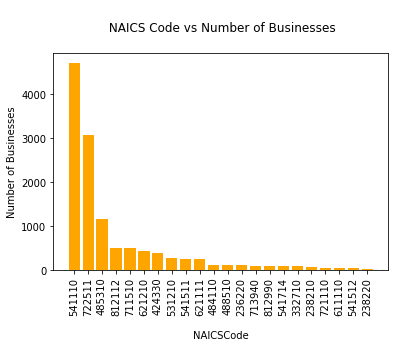

In [39]:
# Barplot for Most Common NAICS Codes
df3=df3.sort_values('Number of Businesses',ascending=False)
import matplotlib.pyplot as plt
plt.bar(df3['NAICSCode'],df3['Number of Businesses'],color='orange')
plt.title("\n NAICS Code vs Number of Businesses\n")
plt.xlabel("\nNAICSCode")
plt.ylabel("Number of Businesses")
plt.xticks(rotation=90)
plt.show()

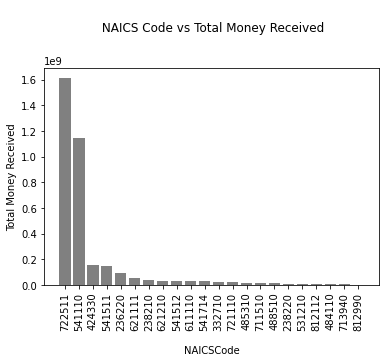

In [40]:
# Barplot for Most Common NAICS Codes
df3=df3.sort_values("Total Money Received",ascending=False)
plt.bar(df3['NAICSCode'],df3['Total Money Received'],color='grey')
plt.title("\n NAICS Code vs Total Money Received\n\n")
plt.xlabel("\nNAICSCode")
plt.ylabel("Total Money Received")
plt.xticks(rotation=90)
plt.show()

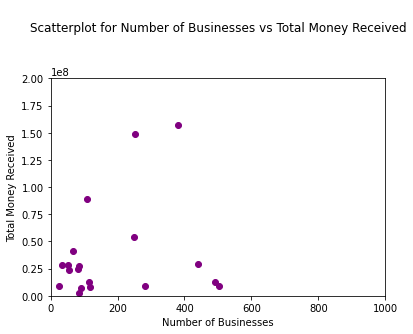

In [41]:
# Scatterplot for 'Number of Businesses' vs 'Total Money Received'
import matplotlib.pyplot as plt
plt.scatter(df3['Number of Businesses'],df3['Total Money Received'],color='purple')
plt.xlim(0,1000)
plt.ylim(0,200000000)
plt.title("\nScatterplot for Number of Businesses vs Total Money Received\n\n")
plt.xlabel("Number of Businesses")
plt.ylabel("Total Money Received")
plt.show()

* **The bar plot indicates that the two most prevalent NAICS codes, based on the number of businesses, are 722511 and 541110.**

* **Furthermore, these two NAICS codes have received the highest total funding.**

* **However, the scatter plot reveals that there is only a weak correlation between the number of businesses (associated with an NAICS code) and the total amount of funding received.** 

## (7) What are the socioeconomic characteristics of the top 100 zip codes? How do they relate to loan amounts?



In [42]:
# We have used 'CurrentApprovalAmount' as the amount of loans (and this column is Numeric)
# We have sorted the result in descending order based on 'Total Money Received'

# We have created a DataFrame 'top_100' for Top 100 Zip Codes that Received Money
top_100=(
    df
    .groupby(F.col('Borrower_Zip'))\
    .agg(F.sum(F.col('CurrentApprovalAmount')).alias('Total Money Received'))\
    .orderBy('Total Money Received',ascending=False)
    .limit(100)
)
top_100.show(10,False)

+------------+--------------------+
|Borrower_Zip|Total Money Received|
+------------+--------------------+
|10018       |1.4913437128799999E9|
|10001       |1.34205863402E9     |
|10017       |8.208705855400004E8 |
|10022       |8.185623723499999E8 |
|10016       |7.695536991600003E8 |
|92618       |7.553928385400014E8 |
|10036       |6.997589153399997E8 |
|60606       |6.542982654800004E8 |
|10019       |6.220365113199998E8 |
|11101       |6.145571476600003E8 |
+------------+--------------------+
only showing top 10 rows



In [43]:
# We have added the Census for the Top 100 Zip Codes to 'top_100' Data Frame
top_100 = top_100.join(df,on='Borrower_Zip',how='inner')

### **Plot 1 : Scatter Plot-'Percentage of Population whose Income is below Poverty Level (18-64yrs)'  vs  'Loan Amount'**

In [44]:
# Converting PySpark Data Frame to an RDD
rdd = top_100.select("people_whose_income_in_past_12m_is_below_poverty_level-percent-18_to_64_years-of-all_people","CurrentApprovalAmount").rdd

#### **Scatter Plot 1A :Percentage of Population whose Income is below Poverty Level (18-64yrs) vs Loan Amount(for all Amounts)**




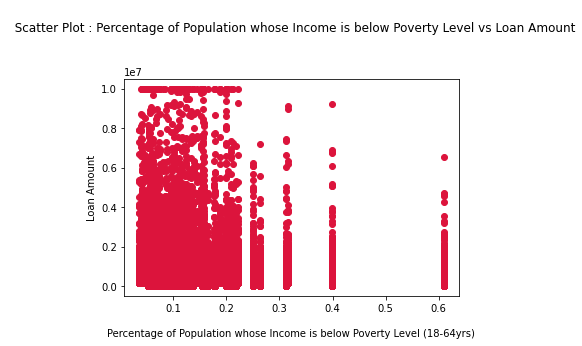

In [45]:
x_vals = rdd.map(lambda x: x[0]).collect()
y_vals = rdd.map(lambda x: x[1]).collect()
plt.scatter(x_vals, y_vals,color='crimson')
plt.title("\n  Scatter Plot : Percentage of Population whose Income is below Poverty Level vs Loan Amount\n\n")
plt.ylabel("Loan Amount")
plt.xlabel("\nPercentage of Population whose Income is below Poverty Level (18-64yrs)")
plt.show()

#### **Scatter Plot 1B: Percentage of Population whose Income is below Poverty Level (18-64yrs) vs Loan Amount (for Loan Amounts greater than 8 Million)**




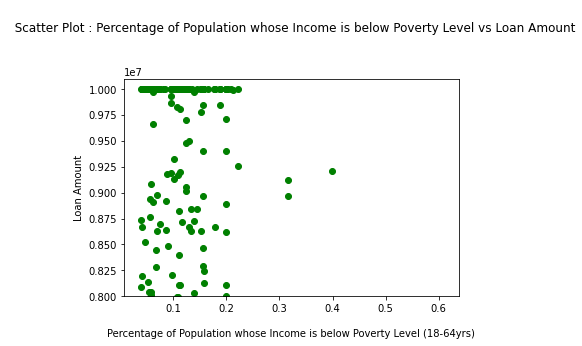

In [46]:
# Scatter Plot : Percentage of Population whose Income is below Poverty Level vs Loan Amount (for Loan Amounts > 8 Million) 
plt.scatter(x_vals, y_vals,color='green')
plt.title("\n  Scatter Plot : Percentage of Population whose Income is below Poverty Level vs Loan Amount\n\n")
plt.ylim(8000000,10100000) # Adding ylim to consider only Loan Amounts greater than 8 Million
plt.ylabel("Loan Amount")
plt.xlabel("\nPercentage of Population whose Income is below Poverty Level (18-64yrs)")
plt.show()

* *The scatter plots illustrate the relationship between loan amount and the percentage of population living below the poverty level in the top 100 zip codes*. 

* *The first scatter plot includes all loan amounts, whereas the second scatter plot only includes loan amounts that are greater than 8 million*.

* *It can be observed that loan amounts exceeding 8 million are only approved for zip codes where the percentage of population with income below poverty level is less than 20%. In other words, loans greater than 8 million are granted only to zip codes where approximately 80% of the population has an income above the poverty level*.

* *There are two reasons why this finding is reasonable. Firstly, individuals with higher incomes are more likely to be able to make the monthly repayments on a large loan. Secondly, banks conduct background and income checks before granting loans, so a high income is typically required to qualify for a larger loan amount. As shown in the plots, zip codes with a higher percentage of population with income above poverty level are more likely to have residents with higher incomes, increasing their chances of being approved for larger loans*.

### **Plot 2 A) : Histogram for Percentage of Foreign Born of Total Population for Top 100 Zip Codes**

In [47]:
# Converting PySpark Data Frame to an RDD
rdd_2 = top_100.select("place_of_birth-percent-foreign_born-of-total_population","CurrentApprovalAmount").rdd

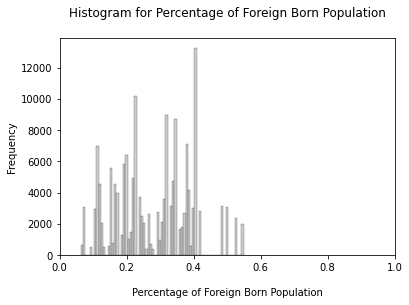

In [48]:
x_vals = rdd_2.map(lambda x: x[0]).collect()
y_vals = rdd_2.map(lambda x: x[1]).collect()
plt.title("Histogram for Percentage of Foreign Born Population\n")
plt.ylabel("Frequency")
plt.xlabel("\nPercentage of Foreign Born Population")
plt.xlim(0,1)
sns.histplot(x_vals,color='silver')
plt.show()

### **Plot 2 B) : Histogram for Percentage of Native Born of Total Population for Top 100 Zip Codes**

In [49]:
# Converting PySpark Data Frame to an RDD
rdd_3 = top_100.select("place_of_birth-percent-born_native-of-total_population","CurrentApprovalAmount").rdd

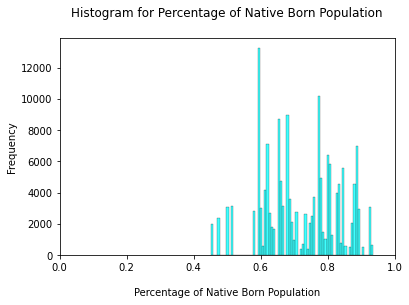

In [50]:
x_vals = rdd_3.map(lambda x: x[0]).collect()
y_vals = rdd_3.map(lambda x: x[1]).collect()
plt.title("Histogram for Percentage of Native Born Population\n")
plt.ylabel("Frequency")
plt.xlabel("\nPercentage of Native Born Population")
plt.xlim(0,1)
sns.histplot(x_vals,color='aqua')
plt.show()

* *By analyzing Histograms 2A and 2B, it is evident that the Top 100 Zip Codes that received the highest amount of money are predominantly those where the Percentage of Native Population is over 60% and the Percentage of Foreign Born Population is below 40%.*

* *It appears that Zip Codes with a higher Percentage of Native Population have received a larger amount of loans, and there could be several reasons for this trend.*

* *One reason for this could be that secured loans require collateral to be pledged in order to secure the loan, and Native people may have more assets available to use as collateral compared to Foreign Nationals.*

* *An additional factor could be that certain types of loans may have citizenship requirements, particularly for loan amounts above a certain limit. This may limit access to loans for Foreign Nationals who are not U.S. citizens or permanent residents.*

* *The third and perhaps most significant reason is that building a good credit history is crucial for obtaining larger loan amounts. As it takes time to establish a strong credit score, Native people may have an advantage over Foreign Nationals in this regard and may be more likely to have higher credit scores, making them more eligible for larger loans.*

## (8) What are the Top 10 zipcodes that had the highest per capita amount of loans going to Women-Owned businesses?



**We have considered a population limit of at least 1000 people per Zip Code for our analysis since there are certain Zip Codes where the population is less than 1000 corresponding to which there are very extreme values for 'Funding Per Capita'.**

In [51]:
# We have used 'CurrentApprovalAmount' as the amount of loans (and this column is Numeric)
# We have sorted the result in descending order based on 'Funding Per Capita'
# We have used a 'where' condition to consider only "Female Owned" Businesses

print("\nTop 10 Zip Codes with the Highest Per Capita Amount of Loans for Women Owned Businesses\n")

( df
  .where((F.col("Gender")=="Female Owned") & (F.col("sex_and_age-population-total_population")>=1000)) \
  .groupby(F.col("Borrower_Zip").alias("Zip_Code"),'BorrowerState')\
  .agg(F.sum("CurrentApprovalAmount").alias('Total Funds'),F.avg("sex_and_age-population-total_population").alias("Total Population"), \
       F.round(F.sum("CurrentApprovalAmount")/F.avg("sex_and_age-population-total_population"), 2).alias("Funding Per Capita"))\
  .orderBy("Funding Per Capita",ascending=False)\
  .show(10, False))


Top 10 Zip Codes with the Highest Per Capita Amount of Loans for Women Owned Businesses

+--------+-------------+--------------------+----------------+------------------+
|Zip_Code|BorrowerState|Total Funds         |Total Population|Funding Per Capita|
+--------+-------------+--------------------+----------------+------------------+
|90058   |CA           |4.6224949760000005E7|2674.0          |17286.82          |
|90021   |CA           |3.39545002E7        |2954.0          |11494.41          |
|94111   |CA           |3.1174922680000003E7|3432.0          |9083.6            |
|97204   |OR           |9159872.0           |1033.0          |8867.25           |
|60603   |IL           |8747989.0           |1029.0          |8501.45           |
|10018   |NY           |7.317257283999999E7 |9684.0          |7556.03           |
|90067   |CA           |1.602051046E7       |2355.0          |6802.76           |
|92121   |CA           |3.036145665E7       |4588.0          |6617.58           |
|78205  

* **Among the Top 10 Zip Codes with the Highest Per Capita Amount of Loans for Women Owned Businesses, 5 Zip Codes are in California, 2 in Texas , 1 in New York , 1 in Oregon and 1 in Illinois.**

* **The states where these Zip Codes are located are home to major financial institutions that offer high level of support for women-owned businesses. Furthermore, California has the largest number of women-owned businesses, followed by Texas, New York, and Illinois, which is a crucial point to note when we consider Per Capita Amount of Loans for Female Owned Businesses.**